In [ ]:
import os
import sys

if os.path.basename(os.getcwd()) == "testing":
    os.chdir(os.path.dirname(os.getcwd()))
    sys.path.append(os.getcwd())

import struct

import constriction
import lossless.component.core.arm as arm
import lossless.component.core.arm_image as arm_image
import lossless.util.color_transform as color_transform
import matplotlib.pyplot as plt
import numpy as np
import torch
from lossless.component.coolchic import CoolChicEncoder, CoolChicEncoderParameter
from lossless.io.types import POSSIBLE_ENCODING_DISTRIBUTIONS
from lossless.training.manager import ImageEncoderManager
from lossless.util.color_transform import ColorBitdepths
from lossless.configs.config import args
from lossless.util.distribution import (
    discretized_logistic_logp,
    get_mu_and_scale_colorreg,
    get_scale,
)
from lossless.util.image_loading import load_image_as_tensor
from lossless.util.parsecli import change_n_out_synth, get_coolchic_param_from_args

np.set_printoptions(precision=16)
from _io import BufferedReader


class StopExecution(Exception):
    def _render_traceback_(self):
        return []


class MonochromeBitdepths(color_transform.ColorBitdepths):
    def __init__(self) -> None:
        self.bitdepths = [8]
        self.scaling_factors = [255]
        self.bins = [256]
        self.ranges_int = [[0, 255]]


DEFAULT_LOGSCALE = 13.4
DEFAULT_SHIFT = 0.0
DEFAULT_IMG_VALUE = 0.00802


def plot_logp(shifts: np.ndarray | None, logscales: np.ndarray | None):
    channel_ranges = MonochromeBitdepths()
    x = torch.ones((1, 1, 1, 1)) * DEFAULT_IMG_VALUE

    # shifts is a linspace
    logps = []

    if shifts is not None:
        for shift_value in shifts:
            shift = torch.tensor(shift_value)
            mu = x + shift
            log_scale = torch.clamp(torch.tensor(DEFAULT_LOGSCALE), min=-10.0, max=13.8155)
            scale = torch.exp(-0.5 * log_scale)
            logp = discretized_logistic_logp(mu, scale, x, channel_ranges)
            logps.append(-logp.item())
        plt.plot(shifts, logps)
        plt.xlabel("Shift")
        plt.ylabel("Negative Log Probability")
        plt.title("Negative Log Probability vs Shift")
        plt.show()
    if logscales is not None:
        logps = []
        for logscale_value in logscales:
            shift = torch.tensor(DEFAULT_SHIFT)
            mu = x + shift
            log_scale = torch.clamp(torch.tensor(logscale_value), min=-10.0, max=13.8155)
            scale = torch.exp(-0.5 * log_scale)
            logp = discretized_logistic_logp(mu, scale, x, channel_ranges)
            logps.append(-logp.item())
        plt.plot(logscales, logps)
        plt.xlabel("Log Scale")
        plt.ylabel("Negative Log Probability")
        plt.title("Negative Log Probability vs Log Scale")
        plt.show()


def logp_image(shifts: np.ndarray, logscales: np.ndarray):
    channel_ranges = MonochromeBitdepths()
    x = torch.ones((1, 1, 1, 1)) * DEFAULT_IMG_VALUE

    logp_matrix = np.zeros((len(logscales), len(shifts)))

    for j, shift_value in enumerate(shifts):
        for i, logscale_value in enumerate(logscales):
            shift = torch.tensor(shift_value)
            mu = x + shift
            log_scale = torch.clamp(torch.tensor(logscale_value), min=-10.0, max=13.8155)
            scale = torch.exp(-0.5 * log_scale)
            logp = discretized_logistic_logp(mu, scale, x, channel_ranges)
            logp_matrix[i, j] = -logp.item()

    plt.imshow(
        logp_matrix,
        extent=(shifts[0], shifts[-1], logscales[0], logscales[-1]),
        aspect="auto",
        origin="lower",
    )
    plt.colorbar(label="Negative Log Probability")
    plt.xlabel("Shift")
    plt.ylabel("Log Scale")
    plt.title("Negative Log Probability Heatmap")
    plt.show()


def plot_image_by_channels(image_tensor: torch.Tensor):
    image_np = image_tensor[0].permute(1, 2, 0).cpu().numpy()
    num_channels = image_np.shape[2]
    fig, axes = plt.subplots(1, num_channels, figsize=(5 * num_channels, 5))
    for i in range(num_channels):
        ax = axes[i]  # type: ignore
        im = ax.imshow(image_np[:, :, i], cmap="gray")
        ax.set_title(f"Channel {i+1}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    plt.show()

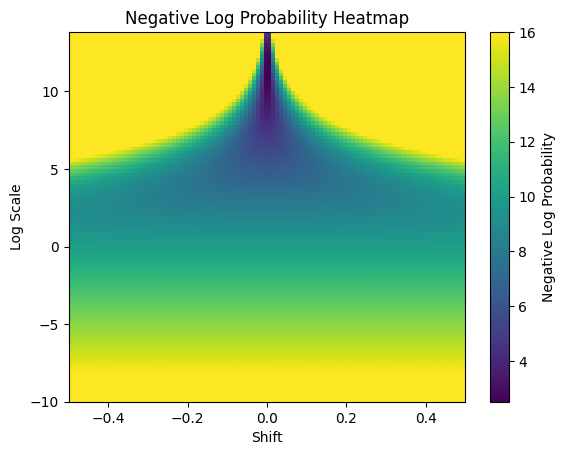

In [2]:
logp_image(np.linspace(-0.5, 0.5, 100), np.linspace(-10.0, 13.8154, 100))

Converting image to YCoCg color space


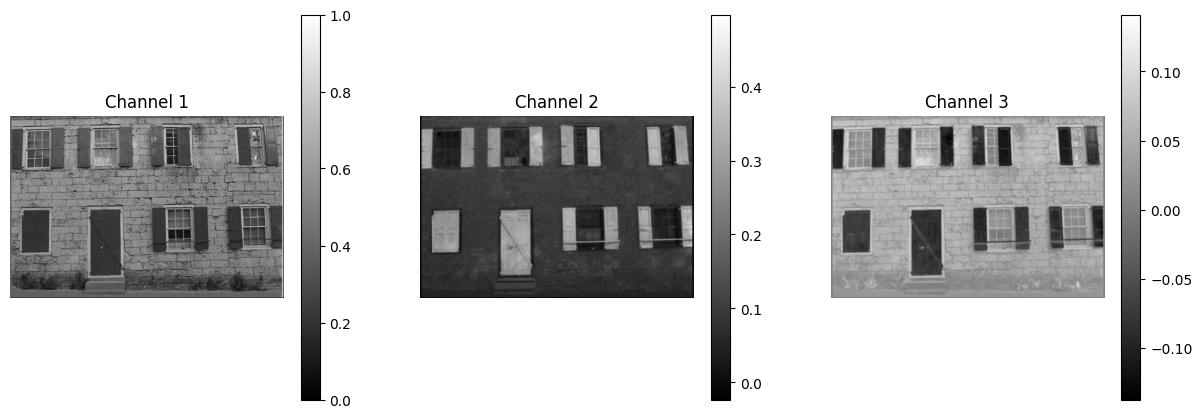

In [9]:
# ==========================================================================================
# LOAD IMAGE
# ==========================================================================================
color_space = "YCoCg"
use_image_arm = True
im_path = "../datasets/kodak/kodim01.png"
im_tensor, colorspace_bitdepths = load_image_as_tensor(
    im_path, device="cuda:0", color_space=color_space
)
plot_image_by_channels(im_tensor)

In [8]:
# ==========================================================================================
# LOAD PRESETS, COOLCHIC PARAMETERS
# ==========================================================================================
image_index = 0
use_color_regression = False
use_image_arm = True
encoder_gain = 64
multi_region_image_arm = False

image_encoder_manager = ImageEncoderManager(preset_name=args["preset"], colorspace_bitdepths=colorspace_bitdepths)
encoder_param = CoolChicEncoderParameter(**get_coolchic_param_from_args(args, "lossless"))
encoder_param.use_color_regression = use_color_regression
encoder_param.encoder_gain = encoder_gain
encoder_param.set_image_size((im_tensor.shape[2], im_tensor.shape[3]))
encoder_param.layers_synthesis = change_n_out_synth(
    encoder_param.layers_synthesis, 9 if use_color_regression else 6
)
encoder_param.use_image_arm = use_image_arm
encoder_param.multi_region_image_arm = multi_region_image_arm
coolchic = CoolChicEncoder(param=encoder_param)
coolchic.to_device("cuda:0")
coolchic.load_state_dict(
    torch.load(
        "../logs/full_runs/2026_01_02_default_name/trained_models/2026_01_02__15_26_42__trained_coolchic_kodak_kodim01_img_rate_3.7748823165893555.pth"
    )
)

<All keys matched successfully>

0.00000, 0.03735, 0.65921
0.00000, 0.00560, 0.19709
0.00000, 0.00432, 0.12612


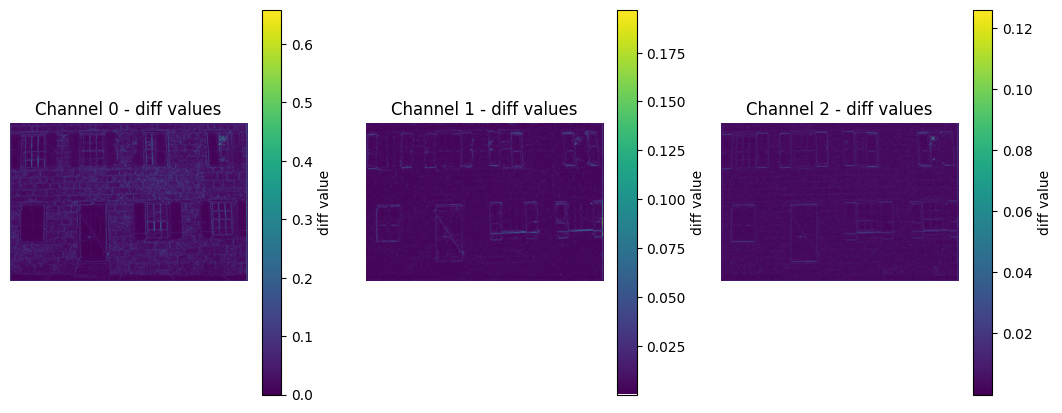

In [11]:
# ==========================================================================================
# Show how predicted mu differs from image
# ==========================================================================================
with torch.no_grad():
    raw_output_dict = coolchic.forward(im_tensor, 'none', "hardround")
    mu, scale = raw_output_dict["mu"].cpu(), raw_output_dict["scale"].cpu()
image = im_tensor.clone().to(mu.device)

# ==========================================================================================
# Visualize diff = abs(mu - image)
# ==========================================================================================
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
for channel in range(3):
    channel_ranges = MonochromeBitdepths()
    mu_slice = mu[:, channel : channel + 1]
    image_slice = image[:, channel : channel + 1]
    diff = abs(mu_slice - image_slice)
    print(f"{diff.min():.5f}, {diff.mean():.5f}, {diff.max():.5f}")
    ax = axes[channel]
    im = ax.imshow(diff[0].permute(1, 2, 0).cpu().numpy(), cmap="viridis")
    ax.set_title(f"Channel {channel} - diff values")
    ax.axis("off")
    fig.colorbar(im, ax=ax, label="diff value")
plt.show()

In [12]:
# ==========================================================================================
# ENCODE LIKE TILL
# ==========================================================================================


def _laplace_cdf(x: torch.Tensor, expectation: torch.Tensor, scale: torch.Tensor) -> torch.Tensor:
    """Compute the laplace cumulative evaluated in x. All parameters
    must have the same dimension.
    Re-implemented here coz it is faster than calling the Laplace distribution
    from torch.distributions.

    Args:
        x (Tensor): Where the cumulative if evaluated.
        expectation (Tensor): Expectation.
        scale (Tensor): Scale

    Returns:
        Tensor: CDF(x, mu, scale)
    """
    shifted_x = x - expectation
    return 0.5 - 0.5 * (shifted_x).sign() * torch.expm1(-(shifted_x).abs() / scale)


def _logistic_cdf(x: torch.Tensor, mu: torch.Tensor, s: torch.Tensor) -> torch.Tensor:
    """Compute the logistic cumulative evaluated in x. All parameters
    must have the same dimension.
    Re-implemented here coz it is faster than calling the Logistic distribution
    from torch.distributions.

    Args:
        x (Tensor): Where the cumulative if evaluated.
        mu (Tensor): Expectation.
        s (Tensor): Scale

    Returns:
        Tensor: CDF(x, mu, scale)
    """
    z = (x - mu) / s
    return torch.sigmoid(z)


def calculate_probability_distribution(
    mu,
    s,
    color_bitdepths: ColorBitdepths,
    distribution: POSSIBLE_ENCODING_DISTRIBUTIONS,
    channel_idx: int,
):
    """Calculate Logistic probability distribution for arithmetic coding.
    Works for any shape of mu and s, adds one dimension at the end for the probability axis.
    """
    # Create the base tensor of quantized values
    new_tensor = torch.linspace(
        0.0,
        (color_bitdepths.ranges_int[channel_idx][1] - color_bitdepths.ranges_int[channel_idx][0])
        / color_bitdepths.scaling_factors[channel_idx],
        steps=color_bitdepths.bins[channel_idx],
        device=mu.device,
    )
    new_shape = (
        *mu.shape,
        color_bitdepths.bins[channel_idx],
    )  # add one dimension at the end
    new_tensor = new_tensor.view(*([1] * mu.ndim), color_bitdepths.bins[channel_idx]).expand(
        *new_shape
    )

    # Compute boundaries for each bin
    x_minus = new_tensor - 0.5 / color_bitdepths.bins[channel_idx]
    x_plus = new_tensor + 0.5 / color_bitdepths.bins[channel_idx]

    # Expand mu and s with one trailing dimension
    mu_expanded = mu.unsqueeze(-1)
    s_expanded = s.unsqueeze(-1)

    # Logistic CDF difference between bin edges (use the logistic cdf function)
    if distribution == "laplace":
        cdf_minus = _laplace_cdf(x_minus, mu_expanded, s_expanded)
        cdf_plus = _laplace_cdf(x_plus, mu_expanded, s_expanded)
    elif distribution == "logistic":
        cdf_minus = _logistic_cdf(x_minus, mu_expanded, s_expanded)
        cdf_plus = _logistic_cdf(x_plus, mu_expanded, s_expanded)
    elif distribution == "dummy":
        cdf_plus = torch.ones_like(x_plus)
        cdf_minus = torch.zeros_like(x_minus)
    else:
        raise ValueError(f"Unknown distribution: {distribution}")
    prob_t = cdf_plus - cdf_minus
    prob_t = torch.clamp_min(prob_t, 2 ** (-16))
    prob_t = prob_t / prob_t.sum(dim=-1, keepdim=True)

    assert torch.all(
        torch.isclose(prob_t.sum(dim=-1), torch.ones_like(mu))
    ), "Probabilities do not sum to 1"
    assert torch.all(prob_t.min() > 0), "Some probabilities are zero"
    return prob_t


def encode(
    x: torch.Tensor,
    mu: torch.Tensor,
    scale: torch.Tensor,
    ct: color_transform.ColorBitdepths = color_transform.YCoCgBitdepths(),
    distribution: POSSIBLE_ENCODING_DISTRIBUTIONS = "logistic",
    output_path="./test-workdir/encoder_size_test/coolchic_encoded.binary",
    preprocessor=lambda x: (x * 255.0).to(torch.int16).cpu(),
):
    x_reshape = preprocessor(x)

    B, C, H, W = x.shape
    enc = constriction.stream.stack.AnsCoder()  # type: ignore
    bits_theoretical = 0

    with torch.no_grad():
        scale_theoretical_bits = 0
        mu = mu.flatten(2, 3).permute(0, 2, 1)  # B, H*W, C
        scale = scale.flatten(2, 3).permute(0, 2, 1)  # B, H*W, C

        probs_logistic = [
            calculate_probability_distribution(
                mu - ct.ranges_int[ch_ind][0] / ct.scaling_factors[ch_ind],
                scale,
                color_bitdepths=ct,
                distribution=distribution,
                channel_idx=ch_ind,
            )
            for ch_ind in range(C)
        ]

        scale_theoretical_bits = 0
        for wh in range(x.shape[2] * x.shape[3]):
            for c in range(x.shape[1]):
                sym: int = (
                    x_reshape.flatten(2, 3).permute(0, 2, 1)[0, -wh - 1, -c - 1]
                ).int().item() - ct.ranges_int[-c - 1][0]
                prob_t = probs_logistic[-c - 1][0, -wh - 1, -c - 1]
                scale_theoretical_bits += -torch.log2(prob_t[sym]).item()
                model = constriction.stream.model.Categorical(  # type: ignore
                    prob_t.detach().cpu().numpy(), perfect=False
                )
                try:
                    enc.encode_reverse(sym, model)
                except Exception as e:
                    print(f"probability: {prob_t}")
                    print(f"Error encoding symbol {sym} for channel {c}: {e}")
                    raise e
        bits_theoretical += scale_theoretical_bits

    bitstream = enc.get_compressed()
    bitstream.tofile(output_path)
    with open(output_path, "rb") as f:
        original_data = f.read()
    with open(output_path, "wb") as f:
        # Pack two 32-bit integers into binary
        f.write(struct.pack("iii", H, W, C))
        f.write(original_data)

    print(f"Theoretical bits per sub pixel: {bits_theoretical/float(W*H*C)}")

    return bitstream, probs_logistic


def decode(
    bitstream_path: str,
    mu: torch.Tensor,
    scale: torch.Tensor,
    ct=color_transform.ColorBitdepths(),
    distribution: POSSIBLE_ENCODING_DISTRIBUTIONS = "logistic",
    postprocessor=lambda x: x.cpu() / 255.0,
):
    with open(bitstream_path, "rb") as f:
        header = f.read(12)  # 3 integers * 4 bytes each
        H, W, C = struct.unpack("iii", header)
    bitstream = np.fromfile(bitstream_path, dtype=np.uint32, offset=12)
    dec = constriction.stream.stack.AnsCoder(bitstream)  # type: ignore

    x = -torch.ones(1, C, H, W)
    with torch.no_grad():
        mu = mu.flatten(2, 3).permute(0, 2, 1)  # B, H*W, C
        scale = scale.flatten(2, 3).permute(0, 2, 1)  # B, H*W, C

        probs_logistic = [
            calculate_probability_distribution(
                mu - ct.ranges_int[ch_ind][0] / ct.scaling_factors[ch_ind],
                scale,
                color_bitdepths=ct,
                distribution=distribution,
                channel_idx=ch_ind,
            )
            for ch_ind in range(C)
        ]
        for h in range(H):
            for w in range(W):
                for c in range(C):
                    prob = probs_logistic[c][0, h * W + w, c]
                    prob_array = prob.detach().cpu().flatten().numpy()
                    model = constriction.stream.model.Categorical(  # type: ignore
                        prob_array, perfect=False
                    )
                    decoded_char = (
                        torch.tensor(dec.decode(model, 1)[0]).float() + ct.ranges_int[c][0]
                    )
                    x[0, c, h, w] = decoded_char

    x = postprocessor(x)

    return x, probs_logistic

In [ ]:
# EXPERIMENT WITH BATCHED LATENT ENCODING
# # ==========================================================================================
# # GET LATENTS AND THEIR PDF PARAMETERS IN BATCH
# # ==========================================================================================
# from lossless.component.core.arm import (
#     _get_neighbor,
#     _laplace_cdf,
# )
# from lossless.component.core.quantizer import (
#     quantize,
# )


# def get_coolchic_latent_pdf(model: CoolChicEncoder):
#     """return bitstream"""
#     quantizer_noise_type = "none"
#     quantizer_type = "hardround"
#     soft_round_temperature = torch.tensor(0.3)
#     noise_parameter = torch.tensor(1.0)
#     AC_MAX_VAL: int = -1

#     with torch.no_grad():
#         encoder_side_flat_latent = torch.cat([latent_i.view(-1) for latent_i in model.latent_grids])

#         flat_decoder_side_latent = quantize(
#             encoder_side_flat_latent * model.encoder_gains,
#             quantizer_noise_type if model.training else "none",
#             quantizer_type if model.training else "hardround",
#             soft_round_temperature,
#             noise_parameter,
#         )
#         print(sorted(flat_decoder_side_latent[:1000].unique().cpu().numpy().tolist()), flat_decoder_side_latent[:1000].unique().numel())
#         # Clamp latent if we need to write a bitstream
#         if AC_MAX_VAL != -1:
#             flat_decoder_side_latent = torch.clamp(
#                 flat_decoder_side_latent, -AC_MAX_VAL, AC_MAX_VAL + 1
#             )

#         decoder_side_latent = []
#         cnt = 0
#         for latent_size in model.size_per_latent:
#             b, c, h, w = latent_size  # b should be one
#             latent_numel = b * c * h * w
#             decoder_side_latent.append(
#                 flat_decoder_side_latent[cnt : cnt + latent_numel].view(latent_size)
#             )
#             cnt += latent_numel
#         assert isinstance(model.non_zero_pixel_ctx_index, torch.Tensor)
#         latent_context_flat = torch.cat(
#             [
#                 _get_neighbor(
#                     spatial_latent_i,
#                     model.mask_size,
#                     model.non_zero_pixel_ctx_index,
#                 )
#                 for spatial_latent_i in decoder_side_latent
#             ],
#             dim=0,
#         )

#         # Get all the B latent variables as a single one dimensional vector
#         flat_latent = torch.cat(
#             [spatial_latent_i.view(-1) for spatial_latent_i in decoder_side_latent],
#             dim=0,
#         )

#         # Feed the spatial context to the arm MLP and get mu and scale
#         flat_mu, flat_scale, flat_log_scale = model.arm(latent_context_flat)
#         print(flat_mu[:10].numpy(), "\n", flat_scale[:10].numpy())
#         # Compute the rate (i.e. the entropy of flat latent knowing mu and scale)
#         proba = torch.clamp_min(
#             _laplace_cdf(flat_latent + 0.5, flat_mu, flat_scale)
#             - _laplace_cdf(flat_latent - 0.5, flat_mu, flat_scale),
#             min=2**-16,  # No value can cost more than 16 bits.
#         )
#         flat_rate = -torch.log2(proba)
#         print(f"Theoretical bits per sub pixel: {flat_rate.sum().item() / (768*512*3)}")
#         return flat_latent, flat_mu, flat_scale, latent_context_flat, flat_decoder_side_latent
# np.set_printoptions(precision=16)
# coolchic.to_device("cpu")
# coolchic.eval()
# flat_latent, flat_mu, flat_scale, latent_context_flat, flat_decoder_side_latent = (
#     get_coolchic_latent_pdf(coolchic)
# )
# flat_latent, flat_mu, flat_scale, latent_context_flat, flat_decoder_side_latent = (
#     flat_latent[:10],
#     flat_mu[:10],
#     flat_scale[:10],
#     latent_context_flat[:10],
#     flat_decoder_side_latent[:10],
# )
# print(coolchic.arm(latent_context_flat)[0].detach().numpy())
# # ==========================================================================================
# # SAVE BATCH LATENTS AND ARM
# # ==========================================================================================
# # save flat_latent, latent_context_flat to a file
# torch.save({
#     "flat_latent": flat_latent,
#     "latent_context_flat": latent_context_flat
# }, "coolchic_latents_snapshot.pt")
# # save coolchic.arm
# torch.save(coolchic.arm.state_dict(), "coolchic_arm.pth")
# # ==========================================================================================
# # SHOW THAT THE BATCHED AND NON-BATCHED ARM GIVE DIFFERENT RESULTS
# # ==========================================================================================
# coolchic.to_device("cpu")
# coolchic.eval()
# os.environ["OMP_NUM_THREADS"]="1"
# os.environ["MKL_NUM_THREADS"]="1"
# torch.set_num_threads(1)
# torch.use_deterministic_algorithms(True)
# with torch.no_grad():
#     mlp = coolchic.arm.mlp
#     def mlp_execute(mlp:torch.nn.Sequential, x):
#         out = x
#         for module in mlp:
#             out = module(out)
#             interesting_part = out[0] if out.shape[0] == 1 else out[1]
#             print(interesting_part.numpy().tolist()[0])
#         return out

#     latent_context_flat = latent_context_flat.to("cpu")
#     print(mlp_execute(mlp, latent_context_flat)[1, 0].item())
#     print("="*100)
#     print(mlp_execute(mlp, latent_context_flat[1][None,:])[:, 0].item())
# # ==========================================================================================
# # ENCODE DECODE LATENTS WITH CONSTANT MU, SCALE
# # ==========================================================================================
# bitstream, probs_enc = encode(
#     x=flat_latent[None, None, None, :],
#     mu=flat_mu[None, None, None, :],
#     scale=flat_scale[None, None, None, :],
#     ct=color_transform.LatentBitdepths(),
#     distribution="laplace",
#     output_path="./test-workdir/encoder_size_test/latent_encoded.binary",
#     preprocessor=lambda x: x.to(torch.int16).cpu(),
# )
# print(
#     os.path.getsize("./test-workdir/encoder_size_test/latent_encoded.binary") * 8 / (image.numel())
# )

# dec, probs_dec = decode(
#     "./test-workdir/encoder_size_test/latent_encoded.binary",
#     mu=flat_mu[None, None, None, :],
#     scale=flat_scale[None, None, None, :],
#     ct=color_transform.LatentBitdepths(),
#     distribution="laplace",
#     postprocessor=lambda x: x.cpu()[0,0,0,:],
# )
# print(torch.allclose(flat_latent.cpu(), dec))

In [13]:
from torch._tensor import Tensor


class EncodeDecodeInterface:
    """This class provides unified interface for encoding and decoding with predictors irrespective of the underying data structure.

    The idea is to abstract the encoding and decoding logic from the specifics of what is being encoded - latents, image pixels, etc.
    """

    def __init__(self, data, predictor) -> None:
        self.data = data
        self.predictor = predictor

    def reset_iterators(self) -> None:
        raise NotImplementedError

    def advance_iterators(self) -> None:
        raise NotImplementedError

    def get_next_predictor_features(self) -> torch.Tensor:
        raise NotImplementedError

    def get_pdf_parameters(self, features: torch.Tensor) -> tuple:
        return self.predictor(features)

    def get_current_element(self):
        raise NotImplementedError

    def set_decoded_element(self, element) -> None:
        raise NotImplementedError

    def get_packing_parameters(self) -> bytes:
        raise NotImplementedError

    def set_packing_parameters(self, bitstream: BufferedReader) -> int:
        raise NotImplementedError

    def get_channel_idx(self) -> int:
        raise NotImplementedError


class LatentEncodeDecodeInterface(EncodeDecodeInterface):
    def __init__(self, data: list[torch.Tensor], predictor: arm.Arm) -> None:
        # latents are a list of tensors of shape [1, C, H, W]
        super().__init__(data, predictor)
        self.predictor = predictor
        self.current_latent_idx = 0
        self.current_spatial_pos = [0, 0, 0, 0]
        self.header_size = 4
        self.testing_stop = -1  # FIXME: temporary stop for testing

    def reset_iterators(self) -> None:
        self.current_latent_idx = 0
        self.current_spatial_pos = [0, 0, 0, 0]

    def _iterator_to_flat_index(self) -> int:
        latent_shape = self.data[self.current_latent_idx].shape
        flat_index = 0
        nested_multiplier = 1
        for index in range(len(self.current_spatial_pos) - 1, -1, -1):
            flat_index += self.current_spatial_pos[index] * nested_multiplier
            nested_multiplier *= latent_shape[index]
        return flat_index

    def _flat_index_to_iterator(self, flat_index: int) -> list[int]:
        latent_shape = self.data[self.current_latent_idx].shape
        res = [0, 0, 0, 0]
        for dim in range(len(self.current_spatial_pos) - 1, -1, -1):
            res[dim] = flat_index % latent_shape[dim]
            flat_index = flat_index // latent_shape[dim]
        return res

    def advance_iterators(self) -> None:
        if self.current_latent_idx >= len(self.data):
            raise StopIteration("All latents have been processed.")

        flat_index = self._iterator_to_flat_index()
        flat_index += 1
        # FIXME: temporary stop for testing
        if flat_index > self.testing_stop and self.testing_stop > 0:
            raise StopIteration("Partial stop for testing.")

        if flat_index >= self.data[self.current_latent_idx].numel():
            # move to next latent
            self.current_latent_idx += 1
            if self.current_latent_idx >= len(self.data):
                raise StopIteration("All latents have been processed.")
            self.current_spatial_pos = [0, 0, 0, 0]
            return
        # compute new spatial pos from flat index
        self.current_spatial_pos = self._flat_index_to_iterator(flat_index)

    def get_next_predictor_features(self) -> torch.Tensor:
        b, c, h, w = self.current_spatial_pos
        latent = self.data[self.current_latent_idx][b, c, :, :]
        context = self.predictor.get_neighbor_context(latent, h=h, w=w)
        return context

    def get_pdf_parameters(self, features: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # I assume that the features have shape [1, context_size]
        # print("Getting PDF parameters for latent index", self.current_latent_idx, "at position", self.current_spatial_pos)
        # print("Features:", features.dtype, features.shape, features)
        # raise StopExecution()
        mu, scale, log_scale = super().get_pdf_parameters(features)
        return mu[0], scale[0]

    def get_current_element(self):
        b, c, h, w = self.current_spatial_pos
        return self.data[self.current_latent_idx][b, c, h, w]

    def set_decoded_element(self, element) -> None:
        b, c, h, w = self.current_spatial_pos
        self.data[self.current_latent_idx][b, c, h, w] = element

    def get_packing_parameters(self) -> bytes:
        # this could
        total_elems = sum([latent.numel() for latent in self.data])
        return struct.pack("i", total_elems)

    def set_packing_parameters(self, bitstream: BufferedReader) -> int:
        header = bitstream.read(self.header_size)
        (total_elems,) = struct.unpack("i", header)
        # FIXME: currently we ignore the packing parameters for latents
        # as we assume fixed size latents known from the model
        return self.header_size

    def get_channel_idx(self) -> int:
        return self.current_spatial_pos[1]


class ImageEncodeDecodeInterface(EncodeDecodeInterface):
    def __init__(self, data: tuple, predictor: arm_image.ImageArm) -> None:
        # raw image data is a tensor of shape [1, C, H, W]
        self.raw_image_data = data[0]
        # raw synth out is a tensor of shape [1, 9, H, W]
        self.raw_synth_out = data[1]
        self.predictor = predictor
        self.predictor = predictor
        self.current_spatial_pos = [0, 0, 0, 0]
        self.header_size = 12  # H, W, C
        self.cutoffs = [
            sum(predictor.synthesis_out_params_per_channel[:i])
            for i in range(len(predictor.synthesis_out_params_per_channel) + 1)
        ]
        self.testing_stop = -1  # FIXME: temporary stop for testing

    def reset_iterators(self) -> None:
        self.current_spatial_pos = [0, 0, 0, 0]

    def _iterator_to_flat_index(self) -> int:
        flat_index = 0
        nested_multiplier = 1
        for dim in range(len(self.current_spatial_pos) - 1, -1, -1):
            flat_index += self.current_spatial_pos[dim] * nested_multiplier
            nested_multiplier *= self.raw_image_data.shape[dim]
        return flat_index

    def _flat_index_to_iterator(self, flat_index: int) -> list[int]:
        res = [0, 0, 0, 0]
        for dim in range(len(self.current_spatial_pos) - 1, -1, -1):
            res[dim] = flat_index % self.raw_image_data.shape[dim]
            flat_index = flat_index // self.raw_image_data.shape[dim]
        return res

    def advance_iterators(self) -> None:
        # FIXME: The order is all wrong here -> we should be encoding pixel by pixel channel by channel,
        # not as current channel first then spatially.
        flat_index = self._iterator_to_flat_index()
        flat_index += 1
        if self.testing_stop > 0 and flat_index > self.testing_stop:
            raise StopIteration("Partial stop for testing.")
        if flat_index >= self.raw_image_data.numel():
            raise StopIteration("All pixels have been processed.")
        # compute new spatial pos from flat index
        self.current_spatial_pos = self._flat_index_to_iterator(flat_index)

    def get_next_predictor_features(self) -> Tensor:
        b, c, h, w = self.current_spatial_pos
        im_r = self.raw_image_data[b, 0, :, :]
        im_g = self.raw_image_data[b, 1, :, :]
        im_b = self.raw_image_data[b, 2, :, :]
        context_r = self.predictor.get_neighbor_context(im_r, h=h, w=w).flatten()
        context_g = self.predictor.get_neighbor_context(im_g, h=h, w=w).flatten()
        context_b = self.predictor.get_neighbor_context(im_b, h=h, w=w).flatten()
        context = torch.cat([context_r, context_g, context_b], dim=0)[None, :]
        r_syn_o = self.raw_synth_out[b, :, h, w]
        im_known = self.raw_image_data[b, :c, h, w]
        full_feature = torch.cat([context, r_syn_o[None, :], im_known[None, :]], dim=1)
        return full_feature

    def get_pdf_parameters(self, features: Tensor) -> tuple:
        current_channel = self.get_channel_idx()
        _, _, h, w = self.current_spatial_pos

        start_idx = self.cutoffs[current_channel] + self.predictor.context_size * 3
        end_idx = self.cutoffs[current_channel + 1] + self.predictor.context_size * 3
        # start_idx = current_channel * 2
        # end_idx = start_idx + 2
        relevant_raw_synth_out = features[:, start_idx:end_idx]

        image_arm_out = self.predictor.inference(
            features,
            relevant_raw_synth_out,
            current_channel,
        )
        mu, log_scale = torch.chunk(image_arm_out, 2, dim=1)
        scale = get_scale(log_scale)
        return mu[0,0], scale[0,0]
        # if current_channel == 0:
        #     mu, log_scale = torch.chunk(image_arm_out, 2, dim=1)
        #     scale = get_scale(log_scale)
        #     return mu[0,0], scale[0,0]
        # elif current_channel == 1:
        #     _mu, log_scale, alpha = torch.chunk(image_arm_out, 3, dim=1)
        #     mu = _mu + alpha * self.raw_image_data[0, current_channel - 1, h, w]
        #     scale = get_scale(log_scale)
        #     return mu[0,0], scale[0,0]
        # elif current_channel == 2:
        #     _mu, log_scale, beta, gamma = torch.chunk(image_arm_out, 4, dim=1)
        #     mu = (
        #         _mu
        #         + beta * self.raw_image_data[0, current_channel - 2, h, w]
        #         + gamma * self.raw_image_data[0, current_channel - 1, h, w]
        #     )
        #     scale = get_scale(log_scale)
        #     return mu[0,0], scale[0,0]
        # raise StopIteration(f"Cannot process channel index {current_channel}")

    def get_current_element(self):
        b, c, h, w = self.current_spatial_pos
        return self.raw_image_data[b, c, h, w]

    def set_decoded_element(self, element) -> None:
        b, c, h, w = self.current_spatial_pos
        self.raw_image_data[b, c, h, w] = element

    def get_packing_parameters(self) -> bytes:
        b, c, h, w = self.raw_image_data.shape
        return struct.pack("iii", h, w, c)

    def set_packing_parameters(self, bitstream: BufferedReader) -> int:
        header = bitstream.read(self.header_size)
        (h, w, c) = struct.unpack("iii", header)
        # FIXME: currently we ignore the packing parameters for the image
        # as we assume fixed size image known apriori. Technically the parameters are
        # in the stream so bpd measurement is unaffected.
        return self.header_size

    def get_channel_idx(self) -> int:
        return self.current_spatial_pos[1]

In [ ]:
from lossless.component.core.quantizer import (
    quantize,
)

def get_quantized_latents(
    model: CoolChicEncoder
):
    """return quantized latents as a list of tensors"""
    quantizer_noise_type = "none"
    quantizer_type = "hardround"
    soft_round_temperature = torch.tensor(0.3)
    noise_parameter = torch.tensor(1.0)
    AC_MAX_VAL: int = -1

    with torch.no_grad():
        encoder_side_latent_sizes = [latent_i.shape for latent_i in model.latent_grids]
        encoder_side_flat_latent = torch.cat([latent_i.view(-1) for latent_i in model.latent_grids])

        flat_decoder_side_latent = quantize(
            encoder_side_flat_latent * model.encoder_gains,
            quantizer_noise_type if model.training else "none",
            quantizer_type if model.training else "hardround",
            soft_round_temperature,
            noise_parameter,
        )

        # Clamp latent if we need to write a bitstream
        if AC_MAX_VAL != -1:
            flat_decoder_side_latent = torch.clamp(
                flat_decoder_side_latent, -AC_MAX_VAL, AC_MAX_VAL + 1
            )
        flat_decoder_side_latent = flat_decoder_side_latent.cpu().to(torch.float32)
        decoder_side_latent = []
        cnt = 0
        for latent_size in encoder_side_latent_sizes:
            b, c, h, w = latent_size  # b should be one
            latent_numel = b * c * h * w
            decoder_side_latent.append(
                flat_decoder_side_latent[cnt : cnt + latent_numel].view(latent_size)
            )
            cnt += latent_numel
        return decoder_side_latent

In [ ]:
# ==========================================================================================
# DECODE WITH PREDICTOR
# ==========================================================================================


def encode_with_predictor(
    enc_dec_interface: EncodeDecodeInterface,
    ct: color_transform.ColorBitdepths = color_transform.YCoCgBitdepths(),
    distribution: POSSIBLE_ENCODING_DISTRIBUTIONS = "logistic",
    output_path="./test-workdir/encoder_size_test/coolchic_encoded.binary",
):
    enc_dec_interface.reset_iterators()
    enc = constriction.stream.stack.AnsCoder()  # type: ignore
    bits_theoretical = 0

    with torch.no_grad():
        symbols_to_encode = []
        prob_distributions = []
        while True:
            try:
                features = enc_dec_interface.get_next_predictor_features()
                # print(features)
                mu, scale = enc_dec_interface.get_pdf_parameters(features)
                # print("Encoding element with mu:", mu.item(), "scale:", scale.item())
                
                ch_ind = enc_dec_interface.get_channel_idx()
                # print(mu.item() * ct.scaling_factors[ch_ind] - ct.ranges_int[ch_ind][0])
                prob_distributions.append(
                    calculate_probability_distribution(
                        mu - ct.ranges_int[ch_ind][0] / ct.scaling_factors[ch_ind],
                        scale,
                        color_bitdepths=ct,
                        distribution=distribution,
                        channel_idx=ch_ind,
                    )
                )
                

                symbols_to_encode.append(
                    enc_dec_interface.get_current_element().int().item() - ct.ranges_int[ch_ind][0]
                )
                # print("Symbol to encode:", symbols_to_encode[-1])
                # print("Probability distribution:", prob_distributions[-1][symbols_to_encode[-1]].item())
                bits_theoretical += -torch.log2(
                    prob_distributions[-1][symbols_to_encode[-1]]
                ).item()
                enc_dec_interface.advance_iterators()
            except StopIteration:
                break

        for symbol_index, symbol_to_encode, prob_distribution in zip(
            list(range(len(symbols_to_encode))),
            reversed(symbols_to_encode),
            reversed(prob_distributions),
        ):
            model = constriction.stream.model.Categorical(  # type: ignore
                prob_distribution.detach().cpu().numpy(), perfect=False
            )
            try:
                enc.encode_reverse(symbol_to_encode, model)
            except Exception as e:
                print(f"probability: {prob_distribution}")
                print(f"Error encoding symbol {symbol_to_encode} at index {symbol_index}")
                raise e

    bitstream = enc.get_compressed()
    bitstream.tofile(output_path)
    with open(output_path, "rb") as f:
        original_data = f.read()
    with open(output_path, "wb") as f:
        # Pack two 32-bit integers into binary
        f.write(enc_dec_interface.get_packing_parameters())
        f.write(original_data)

    print(f"Theoretical bits per sub pixel: {bits_theoretical/len(symbols_to_encode)}")

    return bitstream, symbols_to_encode, prob_distributions


def decode_quick_check(
    bitstream_path: str,
    prob_distributions: list[torch.Tensor],
    ct: color_transform.ColorBitdepths = color_transform.YCoCgBitdepths(),
    offset: int = 4,
):
    with open(bitstream_path, "rb") as f:
        header = f.read(offset)  # 3 integers * 4 bytes each
        num_symbols = struct.unpack("i" * (offset // 4), header)
    bitstream = np.fromfile(bitstream_path, dtype=np.uint32, offset=offset)
    dec = constriction.stream.stack.AnsCoder(bitstream)  # type: ignore

    decoded_symbols = []
    with torch.no_grad():
        for prob_distribution in prob_distributions:
            prob_array = prob_distribution.detach().cpu().flatten().numpy()
            model = constriction.stream.model.Categorical(prob_array, perfect=False)  # type: ignore
            decoded_char = torch.tensor(dec.decode(model, 1)[0]) + ct.ranges_int[0][0]
            decoded_symbols.append(decoded_char.item())
    return decoded_symbols


def decode_with_predictor(
    bitstream_path: str,
    enc_dec_interface: EncodeDecodeInterface,
    ct=color_transform.ColorBitdepths(),
    distribution: POSSIBLE_ENCODING_DISTRIBUTIONS = "logistic",
):
    enc_dec_interface.reset_iterators()
    with open(bitstream_path, "rb") as f:
        offset = enc_dec_interface.set_packing_parameters(f)
    print(f"offset: {offset}")
    bitstream = np.fromfile(bitstream_path, dtype=np.uint32, offset=offset)
    dec = constriction.stream.stack.AnsCoder(bitstream)  # type: ignore

    with torch.no_grad():
        symbols_decoded = []
        prob_distributions = []
        while True:
            try:
                features = enc_dec_interface.get_next_predictor_features()
                mu, scale = enc_dec_interface.get_pdf_parameters(features)
                ch_ind = enc_dec_interface.get_channel_idx()
                prob_distributions.append(
                    calculate_probability_distribution(
                        mu - ct.ranges_int[ch_ind][0] / ct.scaling_factors[ch_ind],
                        scale,
                        color_bitdepths=ct,
                        distribution=distribution,
                        channel_idx=ch_ind,
                    )
                )
                model = constriction.stream.model.Categorical(  # type: ignore
                    prob_distributions[-1].detach().cpu().numpy(), perfect=False
                )
                symbols_decoded.append(
                    (torch.tensor(dec.decode(model, 1)[0]) + ct.ranges_int[ch_ind][0]).item()
                )
                enc_dec_interface.set_decoded_element(symbols_decoded[-1])
                enc_dec_interface.advance_iterators()
            except StopIteration:
                break
    return symbols_decoded, prob_distributions


DEVICE = "cpu"
coolchic.to_device(DEVICE)
coolchic.eval()
torch.use_deterministic_algorithms(True)
with torch.no_grad():
    num_test_latents = 10
    coolchic_latents = get_quantized_latents(coolchic)
    latent_tensors = [coolchic_latents[i].clone().to("cpu") for i in range(len(coolchic_latents))]
    latent_tensors_zeroed = [torch.zeros_like(tensor) for tensor in latent_tensors]
    ct_latent = color_transform.LatentBitdepths()

    latent_interface_encode = LatentEncodeDecodeInterface(latent_tensors, coolchic.arm)
    latent_interface_encode.testing_stop = num_test_latents
    # ==========================================================================================
    # QUICK ENCODE-DECODE CHECK
    # ==========================================================================================
    bitstream, latent_symbols_to_encode, latent_prob_distributions = encode_with_predictor(
        latent_interface_encode,
        ct=ct_latent,
        distribution="laplace",
        output_path="./test-workdir/encoder_size_test/latent_encoded.binary",
    )
    print(
        f"Actual bits per latent symbol: ",
        os.path.getsize("./test-workdir/encoder_size_test/latent_encoded.binary")
        * 8
        / image.numel(), image.shape
    )
    decoded_latent_symbols = decode_quick_check(
        "./test-workdir/encoder_size_test/latent_encoded.binary",
        latent_prob_distributions,
        ct=ct_latent,
    )
    decoded_latent_symbols = torch.tensor(decoded_latent_symbols)
    latent_symbols_to_encode = torch.tensor(latent_symbols_to_encode) + ct_latent.ranges_int[0][0]
    assert torch.equal(latent_symbols_to_encode, decoded_latent_symbols), "Quick check failed: decoded symbols do not match encoded symbols"
    print("Latent encoding-decoding quick check successful!")

    # ==========================================================================================
    # FULL DECODE WITH PREDICTOR
    # ==========================================================================================
    latent_interface_decode = LatentEncodeDecodeInterface(
        latent_tensors_zeroed, coolchic.arm
    )
    latent_interface_decode.testing_stop = num_test_latents
    decoded_latent_symbols_full, latent_prob_distributions_full = decode_with_predictor(
        "./test-workdir/encoder_size_test/latent_encoded.binary",
        latent_interface_decode,
        ct=ct_latent,
        distribution="laplace",
    )
    decoded_latent_symbols_full = torch.tensor(decoded_latent_symbols_full)
    assert torch.equal(latent_symbols_to_encode, decoded_latent_symbols_full), "Full decode check failed: decoded symbols do not match encoded symbols"
    print("Latent full encoding-decoding check successful!")

In [ ]:
cool_chic_raw_synth_out = coolchic.get_latents_raw_synth_out(
    quantizer_noise_type="none",
    quantizer_type="hardround",
)
im_tensor = im_tensor.to(DEVICE)
im_tensor_int = (im_tensor * 255.0).to(torch.int16)
h, w = im_tensor_int.shape[2], im_tensor_int.shape[3]
with torch.no_grad():
    im_zeroed = torch.zeros_like(im_tensor_int)
    ct_image = color_transform.YCoCgBitdepths()
    num_pixels_tested = 1000
    image_interface_encode = ImageEncodeDecodeInterface((im_tensor_int[:, :, :h//2, :w//2], cool_chic_raw_synth_out[:, :, :h//2, :w//2]), coolchic.image_arm[0])
    image_interface_encode.testing_stop = num_pixels_tested
    # ==========================================================================================
    # QUICK ENCODE-DECODE CHECK
    # ==========================================================================================
    bitstream, image_symbols_to_encode, image_prob_distributions = encode_with_predictor(
        image_interface_encode,
        ct=ct_image,
        distribution="logistic",
        output_path="./test-workdir/encoder_size_test/image_encoded.binary",
    )
    print(
        f"Actual bits per image symbol: ",
        os.path.getsize("./test-workdir/encoder_size_test/image_encoded.binary")
        * 8
        / (len(image_symbols_to_encode)),
    )
    decoded_image_symbols = decode_quick_check(
        "./test-workdir/encoder_size_test/image_encoded.binary",
        image_prob_distributions,
        ct=ct_image,
        offset=12,
    )
    decoded_image_symbols = torch.tensor(decoded_image_symbols)
    image_symbols_to_encode = torch.tensor(image_symbols_to_encode) + ct_image.ranges_int[0][0]
    assert torch.equal(image_symbols_to_encode, decoded_image_symbols), "Quick check failed: decoded symbols do not match encoded symbols"
    print("Image encoding-decoding quick check successful!")

    # ==========================================================================================
    # FULL DECODE WITH PREDICTOR
    # ==========================================================================================
    image_interface_decode = ImageEncodeDecodeInterface(
        (im_zeroed[:, :, :h//2, :w//2], cool_chic_raw_synth_out[:, :, :h//2, :w//2]), coolchic.image_arm[0]
    )
    image_interface_decode.testing_stop = num_pixels_tested
    decoded_image_symbols_full, image_prob_distributions_full = decode_with_predictor(
        "./test-workdir/encoder_size_test/image_encoded.binary",
        image_interface_decode,
        ct=ct_image,
        distribution="logistic",
    )
    decoded_image_symbols_full = torch.tensor(decoded_image_symbols_full)
    
    assert torch.equal(image_symbols_to_encode, decoded_image_symbols_full), "Full decode check failed: decoded symbols do not match encoded symbols"
    print("Image full encoding-decoding check successful!")

In [ ]:
mu, scale = get_mu_and_scale_colorreg(raw_out)
ch = 0
h, w = 0, 0
mu[0,ch,h,w].item(), scale[0,ch,h,w].item()

In [ ]:
os.path.getsize("./test-workdir/encoder_size_test/latent_encoded.binary") * 8 / len(latent_symbols_to_encode)

In [ ]:
print(coolchic.arm.get_neighbor_context([[3.0, 2.0, 2.0]], h=0, w=3))
print(coolchic.arm(coolchic.arm.get_neighbor_context([[3.0, 2.0, 2.0]], h=0, w=3).to(device="cuda")))

In [ ]:
diff = torch.abs(flat_latent.cpu() - dec[0,0,0]).numpy()[:768*512]
print(flat_latent.cpu()[:10])
print(dec[0,0,0][:10])
# print the first index where diff is non zero
print(np.argmax(diff != 0))
print(diff[:100])
plt.imshow(diff.reshape(50, 20), cmap='viridis')
plt.colorbar(label="Absolute Difference")
plt.title("Absolute Difference between Original and Decoded Latent")
plt.show()

## TESTING ENCODE DECODE LOSSLESSNESS

### Cool-Chic Predicted Parameters

In [ ]:
mu, scale = get_mu_and_scale_colorreg(raw_out)

offset = 0
patch_size = 512
patch_image = image[
    :, :, offset : offset + patch_size, offset : offset + patch_size
]
patch_mu = mu[:, :, offset : offset + patch_size, offset : offset + patch_size]
patch_scale = scale[
    :, :, offset : offset + patch_size, offset : offset + patch_size
]

probs_enc = encode(
    patch_image,
    patch_mu,
    patch_scale,
    ct=color_transform.YCoCgBitdepths(),
    distribution="logistic",
    output_path="./test-workdir/encoder_size_test/coolchic_encoded_dummy.binary",
)
dec, probs_dec = decode(
    "./test-workdir/encoder_size_test/coolchic_encoded_dummy.binary",
    patch_mu,
    patch_scale,
    ct=color_transform.YCoCgBitdepths(),
    distribution="logistic",
)

assert torch.allclose(
    patch_image.cpu(), dec.cpu()
), "Decoded image does not match original!"


# rewrite the figure above to subplots with 3 columns and 1 row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for C in range(3):
    axs[C].imshow(dec[0, C, :, :], cmap="gray")
    axs[C].set_title(f"Decoded channel {C}")
plt.show()

### Random Image Patch

In [ ]:
# image = torch.ones((1, 3, 32, 32)) * 0.5
# image[:, 0, :16, :16] = 0.1
# image[:, 1, :16, 16:] = 0.3
# image[:, 2, 16:, :16] = 0.9
image = torch.rand((1, 3, 32, 32))
image[0, 1:] = image[0, 1:] * 2 - 1
image = torch.round(image * 255) / 255

mu = torch.rand_like(image)
scale = torch.rand_like(image)

col_b = color_transform.YCoCgBitdepths()
bitstream, probs_enc = encode(image, mu, scale, ct=col_b, distribution="logistic")
decoded_image, probs_dec = decode("./test-workdir/encoder_size_test/coolchic_encoded.binary", mu, scale, ct=col_b, distribution="logistic")

assert torch.allclose(probs_enc[0], probs_dec[0]), "Probability distributions for channel 0 do not match after encoding and decoding"

# show the original and decoded images side by side. Show the channels separately in a 3 rows and 3 columns layout
fig, axs = plt.subplots(3, 3, figsize=(15, 9))
diff = torch.abs(image - decoded_image)
channel_names = ['Red', 'Green', 'Blue']
for i in range(3):
    axs[i, 0].imshow(image[0, i].cpu(), cmap='gray', vmin=0, vmax=1)
    axs[i, 0].set_title(f'Original {channel_names[i]} Channel min {image[0, i].min().item():.2f} max {image[0, i].max().item():.2f}')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(decoded_image[0, i].cpu(), cmap='gray', vmin=0, vmax=1)
    axs[i, 1].set_title(f'Decoded {channel_names[i]} Channel min {decoded_image[0, i].min().item():.2f} max {decoded_image[0, i].max().item():.2f}')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(diff[0, i].cpu(), cmap='gray', vmin=0, vmax=1)
    axs[i, 2].set_title(f'Difference {channel_names[i]} Channel min {diff[0, i].min().item():.2f} max {diff[0, i].max().item():.2f}')
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()


print(f"Max difference between original and decoded image: {diff.max().item()}")
# show diff channel by channel
assert torch.allclose(image, decoded_image, atol=1e-6)
print("Encode-decode losslessness test passed!")